# COVID-19

This notebook analyzes the growth of the COVID-19 pandemy. It relies on the data provided by Johns Hopkins CSSE at https://github.com/CSSEGISandData/COVID-19 . The main question is: how will the number of infected people change over time. We will use a very simple approach, that should not be used for serious predictions of spreads of deseases, but which is well supported in PySpark. For a better mathematical model, please read https://de.wikipedia.org/wiki/SIR-Modell . Unfortunately there is no support in PySpark for estimating model parameters within a more meaningful model. 

So this notebook is mainly about getting some basic insights into machine learning with PySpark.

# 0. Spark Context & Imports

In [460]:
import matplotlib.pyplot as plt

In [461]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","64G") \
        .getOrCreate()

spark

In [462]:
%matplotlib inline

# 1. Load Data

The original data is available at https://github.com/CSSEGISandData/COVID-19 provided by Johns Hopkins CSSE. There are several different representations of the data, we will peek into different versions and then select the most appropriate to work with.

In [2]:
basedir = '/dimajix/data/COVID-19/csse_covid_19_data'

## 1.1 Load Time Series

The repository already contains time series data. This is nice to look at, but specifically for PySpark maybe a little bit hard to work with. Each line in the file contains a full time series of the number of positive tested persons. This means that the number of columns change with every update. 

In [3]:
series = spark.read\
    .option("header", True) \
    .csv(basedir + "/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
series.toPandas()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
0,None,Afghanistan,33.0,65.0,0,0,0,0,0,0,...,94,110,110,120,170,174,237,273,281,299
1,None,Albania,41.1533,20.1683,0,0,0,0,0,0,...,174,186,197,212,223,243,259,277,304,333
2,None,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,367,409,454,511,584,716,847,986,1171,1251
3,None,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,224,267,308,334,370,376,390,428,439,466
4,None,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,4,4,5,7,7,7,8,8,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,None,Burundi,-3.3731,29.9189,0,0,0,0,0,0,...,0,0,0,0,0,2,2,3,3,3
255,None,Sierra Leone,8.460555000000001,-11.779889,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,2,4
256,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,2
257,None,Malawi,-13.254307999999998,34.301525,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,3,4


## 1.2 Load Daily Reports

The repository also contains more detailed files containing the daily reports of the total number of positively tested persons. Within those files, every line represents exactly one region and one time. Therefore the schema stays stable with every update, only new records are appended. But there are some small technical challenges that we need to take. 

### Date parser helper

First small challenge: All records contain a date, some of them a datetime. But the format has changed several times. In order to handle the different cases, we provide a small PySpark UDF (User Defined Function) that is capable of parsing all formats and which returns the extracted date.

In [191]:
import datetime
from pyspark.sql.types import *

@f.udf(DateType())
def parse_date(date):
    if "/" in date:
        date = date.split(" ")[0]
        (m,d,y) = date.split("/")
        y = int(y)
        m = int(m)
        d = int(d)
        if (y < 2000):
            y += 2000
    else:
        date = date[0:10]
        (y,m,d) = date.split("-")
        y = int(y)
        m = int(m)
        d = int(d)
    return datetime.date(year=y,month=m,day=d)

#print(parse_date("2020-03-01"))
#print(parse_date("1/22/2020"))
#print(parse_date("2020-03-01T23:45:50"))


### Read in data, old schema

Next challenge is that the schema did change, namely between 2020-03-21 and 2020-03-22. The column names have changed, new columns have been added and so on. Therefore we cannot read in all files within a single `spark.read.csv`, but we need to split them up into two separate batches with different schemas.

In [241]:
# Last date to read
today = datetime.date.today()
# First date to read
start_date = datetime.date(2020, 1, 22)
# First date with new schema
schema_switch_date = datetime.date(2020, 3, 22)

The first bunch of files is stored as CSV and has the following columns:
* `Province_State`
* `Country_Region`
* `Last_Update` date of the last update
* `Confirmed` the number of confirmed cases
* `Deaths` the number of confirmed cases, which have died
* `Recovered` the number of recovered cases
* `Latitude` and `Longitude` geo coordinates of the province

The metrics (confirmed, deaths and recovered) are always totals, they already contain all cases from the past.

In [242]:
daily_reports_dir = basedir + "/csse_covid_19_daily_reports"

# Define old schema for first batch of files
schema_1 = StructType([
    StructField("Province_State", StringType()),
    StructField("Country_Region", StringType()),
    StructField("Last_Update", StringType()),
    StructField("Confirmed", LongType()),
    StructField("Deaths", LongType()),
    StructField("Recovered", LongType()),
    StructField("Latitude", DoubleType()),
    StructField("Longitude", DoubleType()),
])

# Generate all dates with old schema
schema_1_dates = [start_date + datetime.timedelta(days=d) for d in range(0,(schema_switch_date - start_date).days)]
# Generate file names with old schema
schema_1_files = [daily_reports_dir + "/" + d.strftime("%m-%d-%Y") + ".csv" for d in schema_1_dates]

# Read in all files with old schema
cases_1 = spark.read\
    .schema(schema_1) \
    .option("header", True) \
    .csv(schema_1_files)

# Peek inside
cases_1.toPandas()

,Province_State,Country_Region,Last_Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21T10:13:08,67800.0,3139.0,58946.0,30.9756,112.2707
1,None,Italy,2020-03-21T17:43:03,53578.0,4825.0,6072.0,41.8719,12.5674
2,None,Spain,2020-03-21T13:13:30,25374.0,1375.0,2125.0,40.4637,-3.7492
3,None,Germany,2020-03-21T20:43:02,22213.0,84.0,233.0,51.1657,10.4515
4,None,Iran,2020-03-21T11:13:12,20610.0,1556.0,7635.0,32.4279,53.6880
...,...,...,...,...,...,...,...,...
7612,Yunnan,Mainland China,1/22/2020 17:00,1.0,NaN,NaN,NaN,NaN
7613,Zhejiang,Mainland China,1/22/2020 17:00,10.0,NaN,NaN,NaN,NaN
7614,None,Japan,1/22/2020 17:00,2.0,NaN,NaN,NaN,NaN
7615,None,Thailand,1/22/2020 17:00,2.0,NaN,NaN,NaN,NaN


### Read in data, new schema

Now we perform exactly the same logical step, we read in all files with the new schema. The second bunch of files is stored as CSV and has the following columns:
* `FIPS` country code
* `Admin2` administrative name below province (i.e. counties)
* `Province_State`
* `Country_Region`
* `Last_Update` date of the last update
* `Latitude` and `Longitude` geo coordinates of the province
* `Confirmed` the number of confirmed cases
* `Deaths` the number of confirmed cases, which have died
* `Recovered` the number of recovered cases
* `Active` the number of currently active cases
* `Combined_Key` a combination of `Admin2`, `Province_State` and `Country_Region`

The metrics (confirmed, deaths and recovered) are always totals, they already contain all cases from the past.

In [243]:
from pyspark.sql.types import *

daily_reports_dir = basedir + "/csse_covid_19_daily_reports"

# New schema
schema_2 = StructType([
    StructField("FIPS", StringType()),
    StructField("Admin2", StringType()),
    StructField("Province_State", StringType()),
    StructField("Country_Region", StringType()),
    StructField("Last_Update", StringType()),
    StructField("Latitude", DoubleType()),
    StructField("Longitude", DoubleType()),
    StructField("Confirmed", LongType()),
    StructField("Deaths", LongType()),
    StructField("Recovered", LongType()),
    StructField("Active", LongType()),
    StructField("Combined_Key", StringType())
])

# Generate all dates with new schema
schema_2_dates = [schema_switch_date + datetime.timedelta(days=d) for d in range(0,(today- schema_switch_date).days)]
# Generate file names with new schema
schema_2_files = [daily_reports_dir + "/" + d.strftime("%m-%d-%Y") + ".csv" for d in schema_2_dates]

# Read in all CSV files with new schema
cases_2 = spark.read\
    .schema(schema_2)  \
    .option("header", True) \
    .csv(schema_2_files)

cases_2.toPandas()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001,Abbeville,South Carolina,US,2020-03-30 22:52:45,34.223334,-82.461707,3,0,0,0,"Abbeville, South Carolina, US"
1,22001,Acadia,Louisiana,US,2020-03-30 22:52:45,30.295065,-92.414197,11,1,0,0,"Acadia, Louisiana, US"
2,51001,Accomack,Virginia,US,2020-03-30 22:52:45,37.767072,-75.632346,6,0,0,0,"Accomack, Virginia, US"
3,16001,Ada,Idaho,US,2020-03-30 22:52:45,43.452658,-116.241552,113,2,0,0,"Ada, Idaho, US"
4,19001,Adair,Iowa,US,2020-03-30 22:52:45,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"
...,...,...,...,...,...,...,...,...,...,...,...,...
49182,None,None,None,Venezuela,2020-03-31 23:43:43,6.423800,-66.589700,135,3,39,93,Venezuela
49183,None,None,None,Vietnam,2020-03-31 23:43:43,14.058324,108.277199,212,0,58,154,Vietnam
49184,None,None,None,West Bank and Gaza,2020-03-31 23:43:43,31.952200,35.233200,119,1,18,100,West Bank and Gaza
49185,None,None,None,Zambia,2020-03-31 23:43:43,-13.133897,27.849332,35,0,0,35,Zambia


### Unify Records

Now we union both data sets `cases_1` and `cases_2` into a bigger data set with a common schema. The target schema should contain the following columns:
* `Country_Region`
* `Province_State`
* `Admin2`
* `Last_Update`
* `Confirmed`
* `Deaths`
* `Recovered`

In case a specific column is not present in onw of the two input DataFrames, simply provide a NULL value (`None` in Python) instead.

In [463]:
all_cases = \
    cases_1.select(
        f.col("Country_Region"),
        f.col("Province_State"),
        f.lit(None).cast(StringType()).alias("Admin2"),
        f.col("Last_Update"),
        f.col("Confirmed"),
        f.col("Deaths"),
        f.col("Recovered")
    ).union(
    cases_2.select(
        f.col("Country_Region"),
        f.col("Province_State"),
        f.col("Admin2"),
        f.col("Last_Update"),
        f.col("Confirmed"),
        f.col("Deaths"),
        f.col("Recovered")
    )
    )

all_cases.toPandas()

,Country_Region,Province_State,Admin2,Last_Update,Confirmed,Deaths,Recovered
0,China,Hubei,None,2020-03-21T10:13:08,67800.0,3139.0,58946.0
1,Italy,None,None,2020-03-21T17:43:03,53578.0,4825.0,6072.0
2,Spain,None,None,2020-03-21T13:13:30,25374.0,1375.0,2125.0
3,Germany,None,None,2020-03-21T20:43:02,22213.0,84.0,233.0
4,Iran,None,None,2020-03-21T11:13:12,20610.0,1556.0,7635.0
...,...,...,...,...,...,...,...
56799,Venezuela,None,None,2020-03-31 23:43:43,135.0,3.0,39.0
56800,Vietnam,None,None,2020-03-31 23:43:43,212.0,0.0,58.0
56801,West Bank and Gaza,None,None,2020-03-31 23:43:43,119.0,1.0,18.0
56802,Zambia,None,None,2020-03-31 23:43:43,35.0,0.0,0.0


## 1.3 Aggragate

The records can contain multiple updates per day. But we only want to have the latest update per province/state on each day. Therefore we perform a simple grouped aggregation and simply pick the maximum of all metrics of interest (`Confirmed`, `Deaths`, `Recovered`).

In [464]:
all_cases_eod = all_cases.groupBy(
        parse_date(f.col("Last_Update")).alias("Last_Update"),
        f.col("Country_Region"),
        f.col("Province_State"),
        f.col("Admin2"),
    ).agg(
        f.max(f.col("Confirmed")).alias("Confirmed"),
        f.max(f.col("Deaths")).alias("Deaths"),
        f.max(f.col("Recovered")).alias("Recovered")
    )

all_cases_eod.show()

+-----------+--------------+--------------+------+---------+------+---------+
|Last_Update|Country_Region|Province_State|Admin2|Confirmed|Deaths|Recovered|
+-----------+--------------+--------------+------+---------+------+---------+
| 2020-03-20|       Estonia|          null|  null|      283|     0|        1|
| 2020-03-20|       Algeria|          null|  null|       90|    11|       32|
| 2020-03-20|     Mauritius|          null|  null|       12|     0|        0|
| 2020-03-19|      Slovenia|          null|  null|      286|     1|        0|
| 2020-03-18|            US|       Indiana|  null|       39|     2|        0|
| 2020-03-07|     Australia|      Victoria|  null|       11|     0|        7|
| 2020-03-17|     Argentina|          null|  null|       68|     2|        3|
| 2020-03-14|         China|      Shandong|  null|      760|     7|      741|
| 2020-03-15|            US|      Nebraska|  null|       17|     0|        0|
| 2020-03-12|            US|    New Mexico|  null|        5|    

## 1.4 Sanity Checks

Since we have now a nice data set containing all records, lets peek inside and let us perform some sanity checks if the numbers are correct.

In [465]:
all_cases_eod.where(f.col("Country_Region") == f.lit("US")) \
    .orderBy(f.col("Confirmed").desc()) \
    .show(truncate=False)

+-----------+--------------+--------------+-------------+---------+------+---------+
|Last_Update|Country_Region|Province_State|Admin2       |Confirmed|Deaths|Recovered|
+-----------+--------------+--------------+-------------+---------+------+---------+
|2020-04-06 |US            |New York      |New York City|72181    |3485  |0        |
|2020-04-05 |US            |New York      |New York City|67551    |2256  |0        |
|2020-04-04 |US            |New York      |New York City|63306    |1905  |0        |
|2020-04-03 |US            |New York      |New York City|57159    |1584  |0        |
|2020-04-02 |US            |New York      |New York City|51809    |1397  |0        |
|2020-04-01 |US            |New York      |New York City|47439    |1139  |0        |
|2020-03-31 |US            |New York      |New York City|43119    |932   |0        |
|2020-03-30 |US            |New York      |New York City|37453    |790   |0        |
|2020-03-29 |US            |New York      |New York City|33768   

### Count cases in US

Let us count the cases in the US for a specific date, maybe compare it to some resource on the web

In [466]:
all_cases_eod.where(f.col("Country_Region") == f.lit("US")) \
    .where(f.col("Last_Update") == f.lit("2020-04-05")) \
    .select(f.sum(f.col("Confirmed"))) \
    .toPandas()

,sum(Confirmed)
0,337072


### Count cases in Germany

In [467]:
all_cases_eod.where(f.col("Country_Region") == f.lit("Germany")) \
    .where(f.col("Last_Update") == f.lit("2020-04-06")) \
    .select(f.sum(f.col("Confirmed"))) \
    .toPandas()

,sum(Confirmed)
0,103374


# 2. Inspect & Visualize

Now that we have a meaningful dataset, let us create some visualizations.

## 2.1 Additional Preparations

Before doing deeper analyzis, we still need to perform some simple preparations in order to make the resuls more meaningful.

### Cases pre country and day

We are not interested in the specific numbers of different provinces or states within a single country. The problem with data per province is that they may contain too few cases for following any theoretical law or for forming any meaningful probability distribution. Therefore we sum up all cases per country per day.

In [473]:
all_country_cases = all_cases_eod.groupBy("Country_Region", "Last_Update") \
    .agg(
        f.sum(f.col("Confirmed")).alias("Confirmed"),
        f.sum(f.col("Deaths")).alias("Deaths"),
        f.sum(f.col("Recovered")).alias("Recovered")
    )

### Calculate age in days

Before continuing, we will add one extra column, namely the day of the epedemy for every country. The desease started on different dates in different countries (start being defined as the date of the first record in the data set). To be able to compare the development of the desease between different countries, it is advisable to add a country specific `day` column, which simply counts the days since the first infection in the particular country.

In [474]:
from pyspark.sql.window import Window

all_countries_age_cases = all_country_cases \
    .withColumn("First_Update", f.min(f.col("Last_Update")).over(Window.partitionBy("Country_Region").orderBy("Last_Update"))) \
    .withColumn("day", f.datediff(f.col("Last_Update"), f.col("First_Update")))

all_countries_age_cases.show()

+--------------+-----------+---------+------+---------+------------+---+
|Country_Region|Last_Update|Confirmed|Deaths|Recovered|First_Update|day|
+--------------+-----------+---------+------+---------+------------+---+
|          Chad| 2020-03-19|        1|     0|        0|  2020-03-19|  0|
|          Chad| 2020-03-21|        1|     0|        0|  2020-03-19|  2|
|          Chad| 2020-03-22|        1|     0|        0|  2020-03-19|  3|
|          Chad| 2020-03-23|        1|     0|        0|  2020-03-19|  4|
|          Chad| 2020-03-24|        3|     0|        0|  2020-03-19|  5|
|          Chad| 2020-03-25|        3|     0|        0|  2020-03-19|  6|
|          Chad| 2020-03-26|        3|     0|        0|  2020-03-19|  7|
|          Chad| 2020-03-27|        3|     0|        0|  2020-03-19|  8|
|          Chad| 2020-03-28|        3|     0|        0|  2020-03-19|  9|
|          Chad| 2020-03-29|        3|     0|        0|  2020-03-19| 10|
|          Chad| 2020-03-30|        5|     0|      

## 2.2 Pick single country

For the whole analysis, we focus on a single country. I decided to pick Germany, but you can also pick a different country.

The selection can easily be done by filtering using the column `Country_Region` to contain the desired country (for example `Germany`).

In [475]:
country_cases = all_countries_age_cases.where(f.col("Country_Region") == "Germany")

# Show first 10 days of data in the correct order
country_cases.orderBy(f.col("day")).show(10)

+--------------+-----------+---------+------+---------+------------+---+
|Country_Region|Last_Update|Confirmed|Deaths|Recovered|First_Update|day|
+--------------+-----------+---------+------+---------+------------+---+
|       Germany| 2020-01-28|        4|  null|     null|  2020-01-28|  0|
|       Germany| 2020-01-29|        4|  null|     null|  2020-01-28|  1|
|       Germany| 2020-01-30|        4|  null|     null|  2020-01-28|  2|
|       Germany| 2020-01-31|        5|  null|     null|  2020-01-28|  3|
|       Germany| 2020-02-01|        8|     0|        0|  2020-01-28|  4|
|       Germany| 2020-02-02|       10|     0|        0|  2020-01-28|  5|
|       Germany| 2020-02-03|       12|     0|        0|  2020-01-28|  6|
|       Germany| 2020-02-07|       13|     0|        0|  2020-01-28| 10|
|       Germany| 2020-02-09|       14|     0|        0|  2020-01-28| 12|
|       Germany| 2020-02-11|       16|     0|        0|  2020-01-28| 14|
+--------------+-----------+---------+------+------

## 2.3 Plot

Let us make a simple plot which shows the number of cases over time.

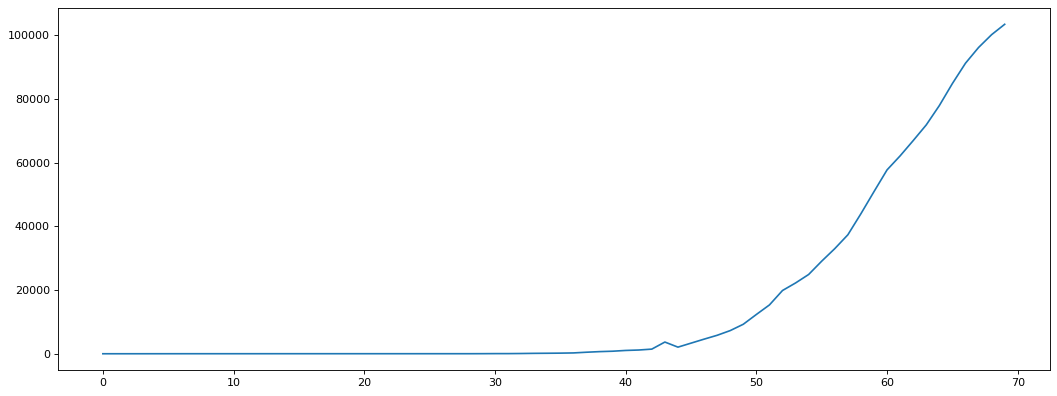

In [476]:
df = country_cases.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df["day"], df["Confirmed"])

### Plot on logarithmic scale

The spread of a epedemy follows an exponential pattern (specifically at the beginning), this can also be seen from the plot above. Therefore it is a good idea to change the scale from a linear scale to a logarithmic scale. With the logarithmic scale, you can spot the relativ rate of increase, which is the slope of the curve. 

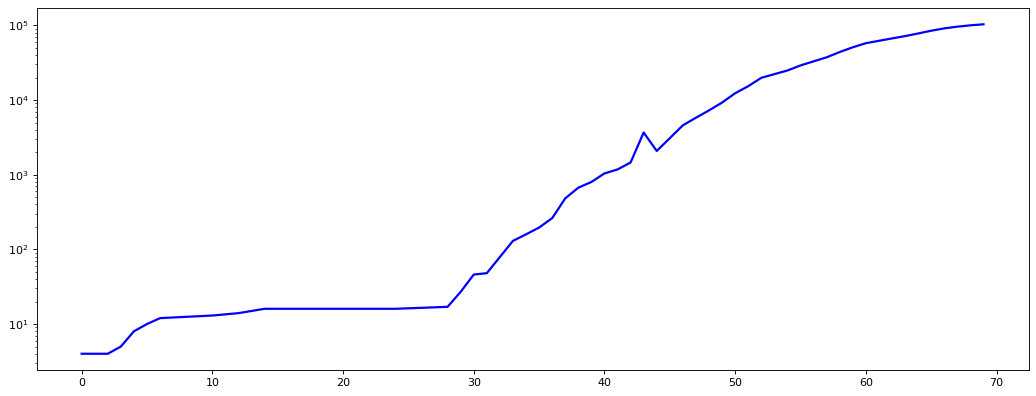

In [477]:
df = country_cases.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.yscale('log')
plt.plot(df["day"], df["Confirmed"], color='blue', lw=2)

### Plot of daily increases

In this case, we are also interested in the number of new cases on every day. This means, that we need to subtract the current number of confirmed cases from the last number of confirmed cases. This is a good example where so called *windowed aggregation* can help us in PySpark. Normally all rows of a DataFrame are processed independently, but for this question (the difference of the number of confirmed cases between two days), we would need to access the rows from two different days. That can be done with window functions.

In [478]:
daily_increase = country_cases.withColumn(
        "Confirmed_Increase", 
        f.col("Confirmed") - f.last(f.col("Confirmed")).over(Window.partitionBy("Country_Region").orderBy("day").rowsBetween(-100,-1))
    )

daily_increase.show(10)

+--------------+-----------+---------+------+---------+------------+---+------------------+
|Country_Region|Last_Update|Confirmed|Deaths|Recovered|First_Update|day|Confirmed_Increase|
+--------------+-----------+---------+------+---------+------------+---+------------------+
|       Germany| 2020-01-28|        4|  null|     null|  2020-01-28|  0|              null|
|       Germany| 2020-01-29|        4|  null|     null|  2020-01-28|  1|                 0|
|       Germany| 2020-01-30|        4|  null|     null|  2020-01-28|  2|                 0|
|       Germany| 2020-01-31|        5|  null|     null|  2020-01-28|  3|                 1|
|       Germany| 2020-02-01|        8|     0|        0|  2020-01-28|  4|                 3|
|       Germany| 2020-02-02|       10|     0|        0|  2020-01-28|  5|                 2|
|       Germany| 2020-02-03|       12|     0|        0|  2020-01-28|  6|                 2|
|       Germany| 2020-02-07|       13|     0|        0|  2020-01-28| 10|        

Now we have an additional column "Confirmed_Increase", which we can now plot. A continuous line plot doesn't make so much sense, since the metric is very discrete by its nature. Therefore we opt for a bar chart instead.

<BarContainer object of 54 artists>

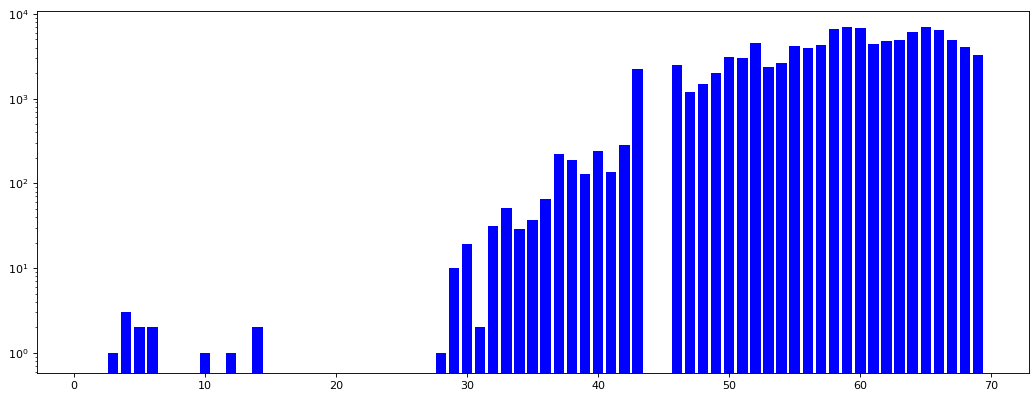

In [479]:
df = daily_increase.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.yscale('log')
plt.bar(df["day"], df["Confirmed_Increase"], color='blue', lw=2)

# 3. Machine Learning

Now we want to use some methods of machine learning in order to predict the further development of the desease within a single country.

In [480]:
# Import relevant packages
from pyspark.ml import *
from pyspark.ml.feature import *
from pyspark.ml.regression import *

## 3.1 Split Data

The very first step in every machine learning project is to split up the whole data into two data sets, the *training data* and the *validation data*. The basic idea is that in order to validate our model, we need some data that was not used during training. That is what the *validation data* will be used for. If we did not exclude the data from the training, we could only infer information about how good the model fits to our data - but we would have no information about how good the model copes with new data. And the second aspect is crucial in prediction applications, where the model will be used on new data points which have never been seen before.

There are different approaches how to do that, but not all approaches work in every scenario. In our use case we are looking at a time series, therefore we need to split the data at a specific date - we need to hide out some information for the training phase. For time series it is important not to perform a random sampling, since this would imply information creep from the future. I.e. if we exclude day 40 and include day 50 in our training data set, day 50 obviously has some information on day 40, which normally would not be available.

In [558]:
all_days = country_cases.select("day").orderBy(f.col("day")).distinct().collect()
all_days = [row[0] for row in all_days]
num_days = len(all_days)
cut_day = all_days[int(0.7*num_days)]
print("cut_day = " + str(cut_day))

# We might want to skip some days where there was no real growth
first_day = 28

training_records = country_cases.where((f.col("day") <= cut_day) & (f.col("day") >= first_day)).cache()
validation_records = country_cases.where(f.col("day") > cut_day).cache()

cut_day = 53


## 3.2 Simple Regression

The most simple approach is to use a very basic linear regression. We skip this super simple approach, since we already know that our data has some exponential ingredients. Therefore we already use a so called *generalized linear model* (GLM), which transforms our values into a logarithmic space before performing a linear regression. Here we already know that this won't work out nicely, since the plots above already indicate a curved shape over time - something a trivial linear model cannot catch. We will take care of that in a later step.

### PySpark ML Pipelines

Spark ML encourages to use so called *pipelines*, which combine a list of transformation blocks. For the very first very simple example, we need two building blocks:
* `VectorAssembler` is required to collect all features into a single column of the special type `Vector`. Most machine learning algorithms require the independant variables (the predictor variables) to packaged together into a single column of type `Vector`. This can be easily done by using the `VectorAssembler`-
* `GeneralizedLinearRegression` provides the regression algorithm a a building block. It needs to be configured with the indepedant variable (the features column), the dependant variable (the label column) and the prediction column where the predictions should be stored in.

In [559]:
pipeline = Pipeline(stages=[
    VectorAssembler(
        inputCols=["day"],
        outputCol="features"
    ),
    GeneralizedLinearRegression(
        family="gaussian", 
        link="log",
        featuresCol="features",
        labelCol="Confirmed",
        predictionCol="Predict"
    )
])

### Fit model

Once we have specified all building blocks in the pipeline, we can *fit* the whole pipeline to obtain a *pipeline model*. The fitting operation either applies a transformation (like the `VectorAssembler`) or recursively fits any embedded estimator (like the `GeneralizedLinearRegression`).

In [560]:
model = pipeline.fit(training_records)

### Perform prediction

One we have obtained the model, it can be used as a transformer again in order to produce predictions. For plotting a graph, we will apply the model not only to the validation set, but to the whole data set. This can be done with the `model.transform` method applied to the `country_cases` DataFrame.

In [561]:
pred = model.transform(country_cases)

### Visualize

Finally we want to visualize the real values and the predictions.

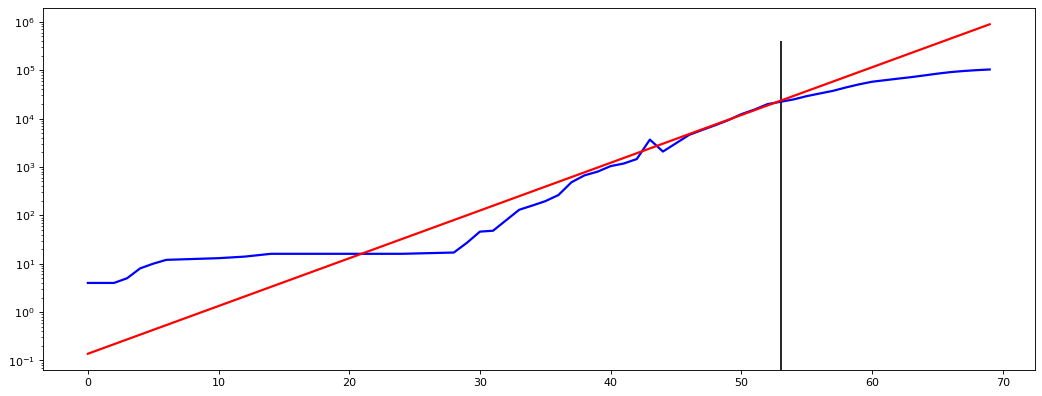

In [562]:
df = pred.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.yscale('log')
plt.plot(df["day"], df["Confirmed"], color='blue', lw=2)
plt.plot(df["day"], df["Predict"], color='red', lw=2)
plt.vlines(cut_day, ymin=0, ymax=400000)

## 3.3 Improve Model

The first shot is not very satisfactory, specifically if looking at the logarithmic plot. The data seems to describe a curve (which is good), we could try to fit a polynom of order 2. This means that we will use (day^2, day, const) as features. This *polynomial expansion* of the original feature `day` can be generated by the `PolynomialExpansion` feature transformer.

This means that we will slightly extend our pipeline as follows.

In [563]:
pipeline = Pipeline(stages=[
    VectorAssembler(
        inputCols=["day"],
        outputCol="day_vec"
    ),
    PolynomialExpansion(
        inputCol="day_vec",
        outputCol="features",
        degree=2
    ),
    GeneralizedLinearRegression(
        family="gaussian", 
        link="log",
        featuresCol="features",
        labelCol="Confirmed",
        predictionCol="Predict"
    )
])

### Fit and predict

Now we will again fit the pipeline to retrieve a model and immediately apply the model to all cases in order to get the data for another plot.

In [564]:
model = pipeline.fit(training_records)
pred = model.transform(country_cases)

### Visualize

The next visualization looks better, especially the critical part of the graph is estimated much better. Note that we did not use data before day 28, since there was no real growth before that day.

Note that our predicted values are above the measured values. This can mean multiple things:
* *Pessimist*: Our model does not perform as good as desired
* *Optimist*: Actions taken by politics change the real model parameters in a favorable way, such that the real number of infections do not grow any more as predicted

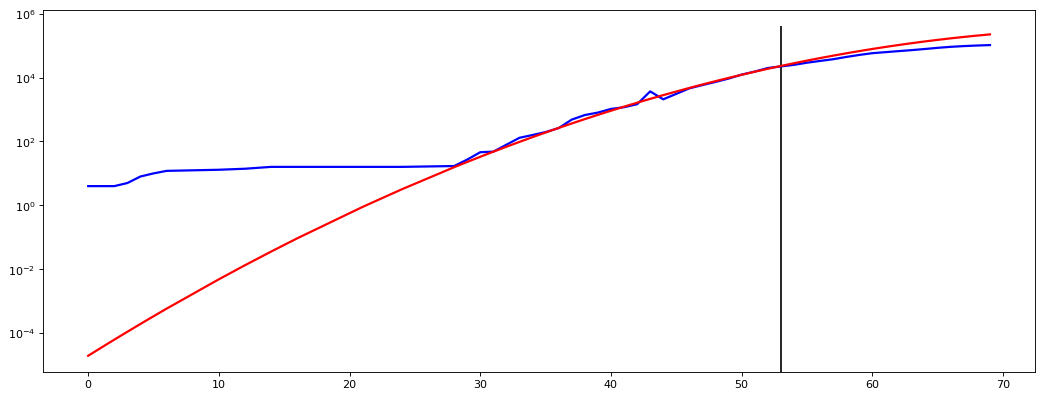

In [565]:
df = pred.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.yscale('log')
plt.plot(df["day"], df["Confirmed"], color='blue', lw=2)
plt.plot(df["day"], df["Predict"], color='red', lw=2)
plt.vlines(cut_day, ymin=0, ymax=400000)

Although the image looks quite promising on the logarithmic scale, let us have a look at the linear scale. We will notice that we overpredict the number of cases by a factor of two and our prediction will look even worse for the future.

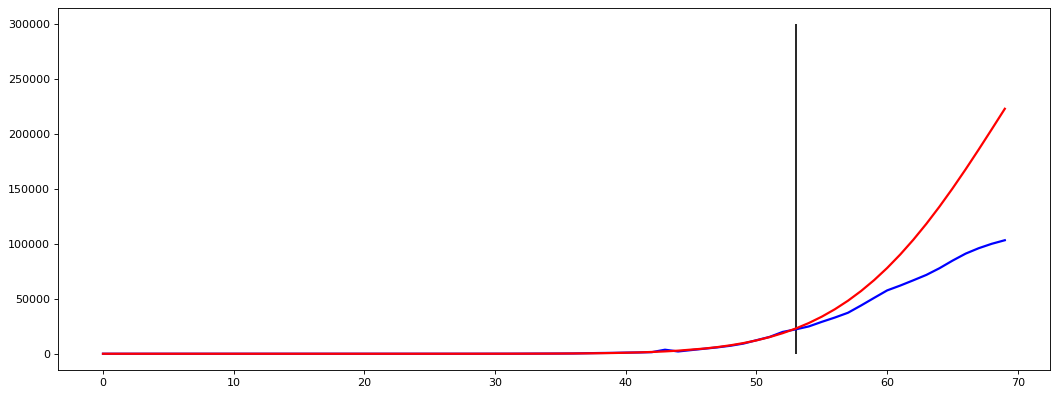

In [566]:
df = pred.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df["day"], df["Confirmed"], color='blue', lw=2)
plt.plot(df["day"], df["Predict"], color='red', lw=2)
plt.vlines(cut_day, ymin=0, ymax=300000)

## 3.5 Change training/validation split

If we change the split of training to validation, things look much better. Of course this might be already expected, since we predict less data, but even the non-logarithmic plot looks really good

In [570]:
# Use 80% for training
cut_day = all_days[int(0.8*num_days)]
print("cut_day = " + str(cut_day))

training_records_80 = country_cases.where((f.col("day") <= cut_day) & (f.col("day") >= first_day)).cache()
validation_records_80 = country_cases.where(f.col("day") > cut_day).cache()

cut_day = 59


In [573]:
model = pipeline.fit(training_records_80)
pred = model.transform(country_cases)

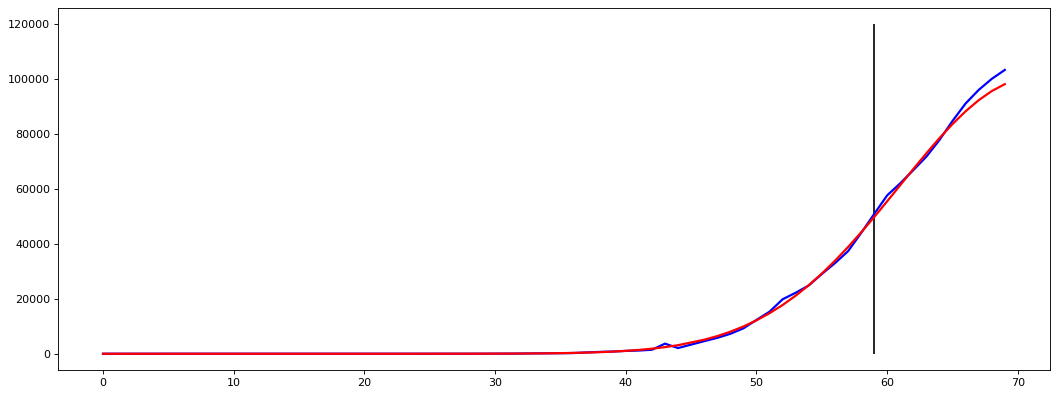

In [574]:
df = pred.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df["day"], df["Confirmed"], color='blue', lw=2)
plt.plot(df["day"], df["Predict"], color='red', lw=2)
plt.vlines(cut_day, ymin=0, ymax=120000)

This result should let you look optimistic into the future, as it may indicate that the underlying process really has changed between day 50 and 60 and that the infection really slows down.

# 4. Final Note

As already mentioned in the beginning, the whole approach is somewhat questionable. We are throwing a very generic machinery at a very specific problem which has a very specific structure. Therefore other approaches involving more meaningful models like https://de.wikipedia.org/wiki/SIR-Modell could give better prediction results. But those models require a completely different numerical approach for fitting the model to the data. We used the tool at hand (in this case PySpark) to generate a model, which does only make very mild (and possibly wrong) assumptions about the development process of the desease. Nevertheless such approaches might also give good results, since on the other hand specific mathematical models also rely on very specific assumptions and simplifications, which may also not be justified.